In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emailsms-hamspam-data-collection/Dataset_10191.csv
/kaggle/input/emailsms-hamspam-data-collection/email.csv
/kaggle/input/emailsms-hamspam-data-collection/spam (1).csv


# Imports

In [2]:
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [3]:
df1 = pd.read_csv('/kaggle/input/emailsms-hamspam-data-collection/Dataset_10191.csv')
df2 = pd.read_csv('/kaggle/input/emailsms-hamspam-data-collection/email.csv')

In [4]:
print(df1.head())
print('='*20)
print(df2.head())

      LABEL                                               TEXT URL EMAIL PHONE
0       ham  Hi! You just spoke to DEEPAK. We'd like to kno...  No    No    No
1       ham                  Yay can't wait to party together!  No    No    No
2       ham                       At what time are you coming.  No    No    No
3  smishing  Dear customer your PAY2TMKYC has been expired,...  No    No   Yes
4       ham  Yo you around? A friend of mine's lookin to pi...  No    No    No
  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...


# 1. Data Cleaning

In [5]:
# Check value counts for each word
df1['LABEL'].value_counts()

LABEL
ham         3397
smishing    3397
spam        3397
Name: count, dtype: int64

In [6]:
# df1['LABEL'] = df1['LABEL'].replace('smishing', 'spam')
# print(df['LABEL'].value_counts())

In [7]:
df2['Category'].value_counts()

Category
ham               4825
spam               747
{"mode":"full"       1
Name: count, dtype: int64

In [8]:
# Rename the columns name so that concat possible.
df1.rename(columns={'LABEL':'label','TEXT':'text'},inplace=True)
df2.rename(columns={'Category':'label','Message':'text'},inplace=True)

In [9]:
print(df1.head())
print('='*20)
print(df2.head())

      label                                               text URL EMAIL PHONE
0       ham  Hi! You just spoke to DEEPAK. We'd like to kno...  No    No    No
1       ham                  Yay can't wait to party together!  No    No    No
2       ham                       At what time are you coming.  No    No    No
3  smishing  Dear customer your PAY2TMKYC has been expired,...  No    No   Yes
4       ham  Yo you around? A friend of mine's lookin to pi...  No    No    No
  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [10]:
# Combine df1 and df2
df = pd.concat([df1,df2],axis=0,ignore_index=True)

In [11]:
df.shape

(15764, 5)

In [12]:
# Checking for duplicated values
df.duplicated().value_counts()

False    13180
True      2584
Name: count, dtype: int64

In [13]:
df.drop_duplicates(inplace=True)

In [14]:
df.duplicated().value_counts()

False    13180
Name: count, dtype: int64

In [15]:
# Checking the information of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13180 entries, 0 to 15763
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   13180 non-null  object
 1   text    13180 non-null  object
 2   URL     8022 non-null   object
 3   EMAIL   8022 non-null   object
 4   PHONE   8022 non-null   object
dtypes: object(5)
memory usage: 617.8+ KB


In [16]:
df.isnull().sum()

label       0
text        0
URL      5158
EMAIL    5158
PHONE    5158
dtype: int64

In [17]:
df.drop(['URL','EMAIL','PHONE'],axis=1,inplace=True)

In [18]:
df.sample(10)

,label,text
398,smishing,Nationwide has noticed your debit card was rec...
9826,spam,"did you see about the new ""divorce barbie""? it..."
3863,ham,Ok im not sure what time i finish tomorrow but...
14394,ham,Are you happy baby ? Are you alright ? Did you...
467,ham,Ok... Sweet dreams...
5894,smishing,todays vodafone numbers ending with 4882 are s...
14366,ham,And pls pls drink plenty plenty water
13486,ham,Beautiful tomorrow never comes.. When it comes...
4311,smishing,urgent. important information for 02 user. tod...
6509,smishing,you experience 1 new voicemail. please call 08...


In [19]:
df['label'].value_counts()

label
ham               7909
smishing          2656
spam              2614
{"mode":"full"       1
Name: count, dtype: int64

In [20]:
# Remove extra values from the data
df = df[df['label'] != '{"mode":"full"']

In [21]:
# Encode the label named 'label' respected to their values
from sklearn.preprocessing import LabelEncoder
ln = LabelEncoder()

In [22]:
df['label'] = ln.fit_transform(df['label'])

# 2. EDA

In [23]:
df.head()

,label,text
0,0,Hi! You just spoke to DEEPAK. We'd like to kno...
1,0,Yay can't wait to party together!
2,0,At what time are you coming.
3,1,"Dear customer your PAY2TMKYC has been expired,..."
4,0,Yo you around? A friend of mine's lookin to pi...


In [24]:
df['label'].value_counts()

label
0    7909
1    2656
2    2614
Name: count, dtype: int64

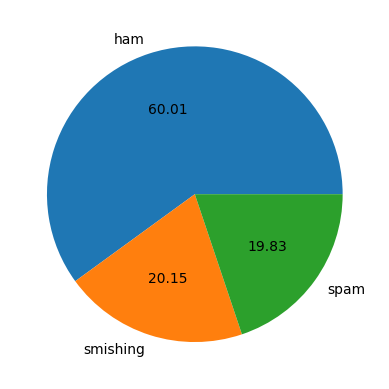

In [25]:
plt.pie(df['label'].value_counts(),labels=['ham','smishing','spam'],autopct='%0.2f')
plt.show()

* Here data is balanced almost so we don't need to balance it.

In [26]:
df['num_char'] = df['text'].apply(len)

In [27]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [28]:
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))

In [29]:
df['num_sentence'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [30]:
df

,label,text,num_char,num_words,num_sentence
0,0,Hi! You just spoke to DEEPAK. We'd like to kno...,122,29,4
1,0,Yay can't wait to party together!,33,8,1
2,0,At what time are you coming.,28,7,1
3,1,"Dear customer your PAY2TMKYC has been expired,...",150,26,2
4,0,Yo you around? A friend of mine's lookin to pi...,65,15,2
...,...,...,...,...,...
15758,2,This is the 2nd time we have tried 2 contact u...,160,35,4
15759,0,Will ü b going to esplanade fr home?,36,9,1
15760,0,"Pity, * was in mood for that. So...any other s...",57,15,2
15761,0,The guy did some bitching but I acted like i'd...,125,27,1


In [31]:
df[['num_char','num_words','num_sentence']].describe()

,num_char,num_words,num_sentence
count,13179.000000,13179.000000,13179.000000
mean,99.568784,21.468928,2.186357
std,60.830184,12.760148,1.491574
min,2.000000,1.000000,1.000000
25%,45.000000,11.000000,1.000000
50%,98.000000,21.000000,2.000000
75%,148.000000,29.000000,3.000000
max,910.000000,220.000000,38.000000


In [32]:
df[df['label']==0][['num_char','num_words','num_sentence']].describe()

,num_char,num_words,num_sentence
count,7909.000000,7909.000000,7909.000000
mean,70.768112,17.248325,1.829688
std,56.769301,13.722235,1.429050
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,91.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [33]:
df[df['label']==1][['num_char','num_words','num_sentence']].describe()

,num_char,num_words,num_sentence
count,2656.000000,2656.000000,2656.000000
mean,145.458961,27.262801,2.655120
std,34.354733,6.845086,1.434324
min,33.000000,7.000000,1.000000
25%,134.000000,25.000000,2.000000
50%,149.000000,28.000000,2.000000
75%,159.000000,31.000000,4.000000
max,392.000000,75.000000,9.000000


<Axes: xlabel='num_char', ylabel='Count'>

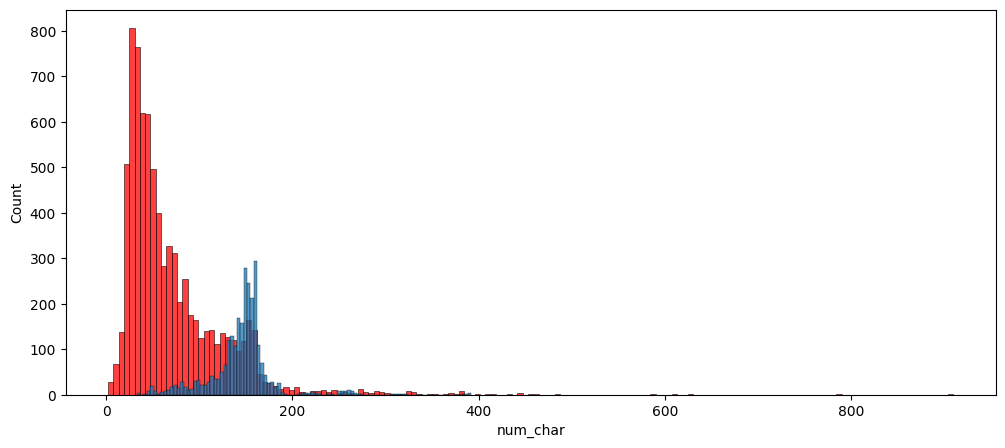

In [34]:
plt.figure(figsize=(12,5))
sns.histplot(df[df['label']==0]['num_char'],color='red')
sns.histplot(df[df['label']==1]['num_char'])

<Axes: xlabel='num_words', ylabel='Count'>

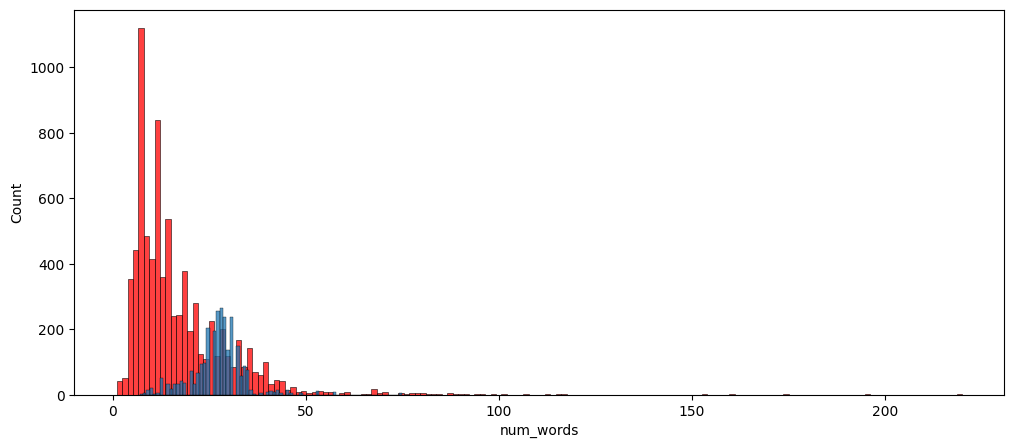

In [35]:
plt.figure(figsize=(12,5))
sns.histplot(df[df['label']==0]['num_words'],color='red')
sns.histplot(df[df['label']==1]['num_words'])

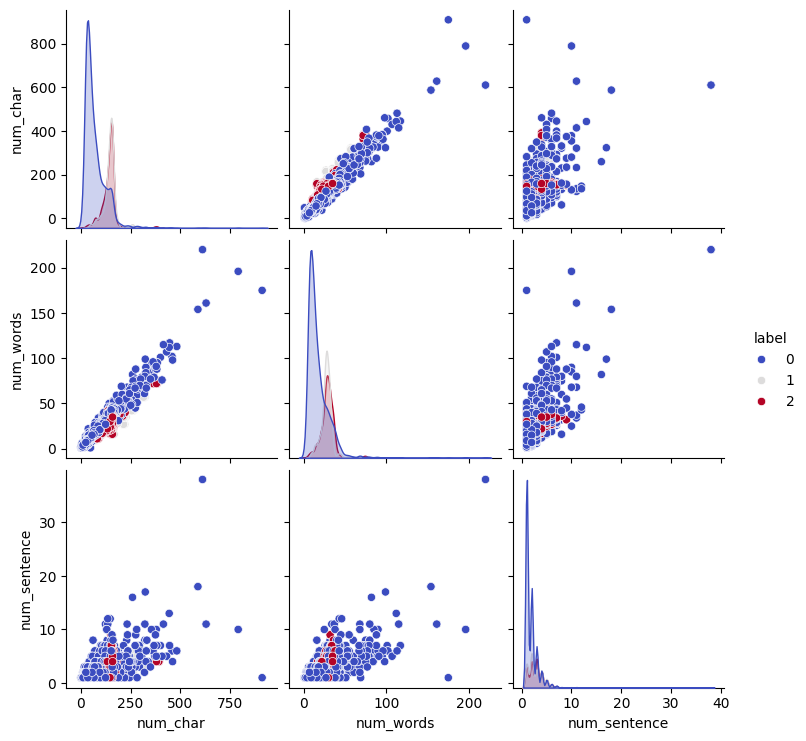

In [36]:
sns.pairplot(df,hue='label',palette='coolwarm')

# 3. Data Preprocessing 
* Lower case
* Tokenization
* Removing special characters
* Removing stop words and punctuation
* Stemming

In [37]:
# Raw text → lowercase → tokenize → remove symbols/stopwords → stem → cleaned text string
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    
    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))
    
            
    return " ".join(y)

In [38]:
ps = PorterStemmer()
ps.stem('loving')

'love'

In [39]:
df['text'][0]

"Hi! You just spoke to DEEPAK. We'd like to know if you were satisfied with the experience. Reply Toll Free with Yes or No."

In [40]:
transform_text("Hi! You just spoke to DEEPAK. We'd like to know if you were satisfied with the experience. Reply Toll Free with Yes or No.")

'hi spoke deepak like know satisfi experi repli toll free ye'

In [41]:
df['transform_text'] = df['text'].apply(transform_text)

In [42]:
df

,label,text,num_char,num_words,num_sentence,transform_text
0,0,Hi! You just spoke to DEEPAK. We'd like to kno...,122,29,4,hi spoke deepak like know satisfi experi repli...
1,0,Yay can't wait to party together!,33,8,1,yay ca wait parti togeth
2,0,At what time are you coming.,28,7,1,time come
3,1,"Dear customer your PAY2TMKYC has been expired,...",150,26,2,dear custom pay2tmkyc expir bl0cked within 24 ...
4,0,Yo you around? A friend of mine's lookin to pi...,65,15,2,yo around friend mine lookin pick later tonight
...,...,...,...,...,...,...
15758,2,This is the 2nd time we have tried 2 contact u...,160,35,4,2nd time tri 2 contact u pound prize 2 claim e...
15759,0,Will ü b going to esplanade fr home?,36,9,1,ü b go esplanad fr home
15760,0,"Pity, * was in mood for that. So...any other s...",57,15,2,piti mood suggest
15761,0,The guy did some bitching but I acted like i'd...,125,27,1,guy bitch act like interest buy someth els nex...


In [43]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

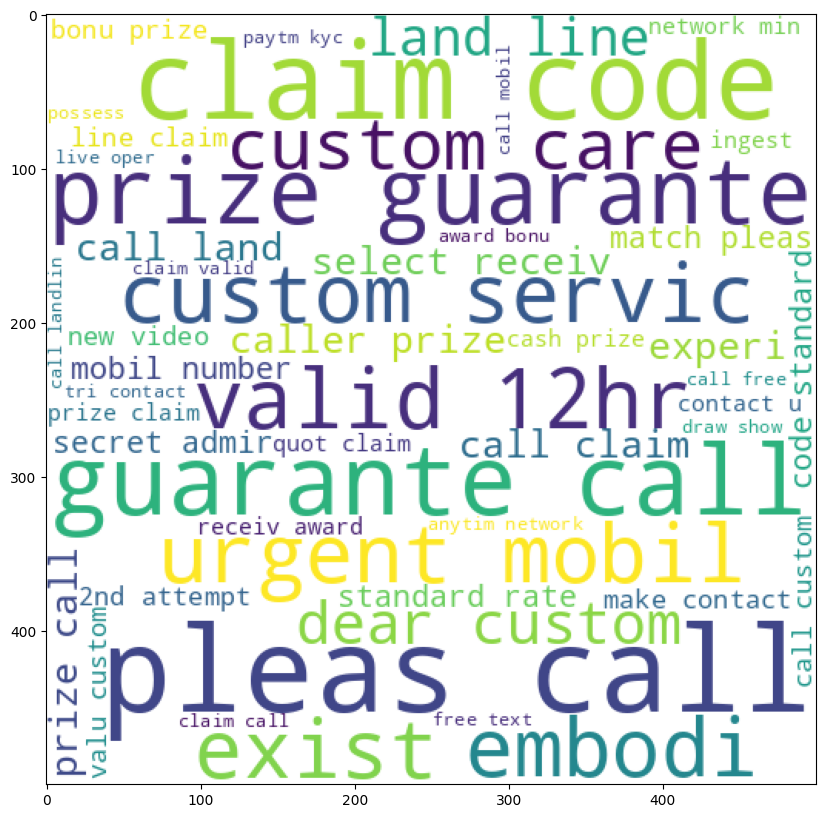

In [44]:
spam_wc = wc.generate(df[df['label'] == 1]['transform_text'].str.cat(sep=" "))
plt.figure(figsize=(15,10))
plt.imshow(spam_wc)

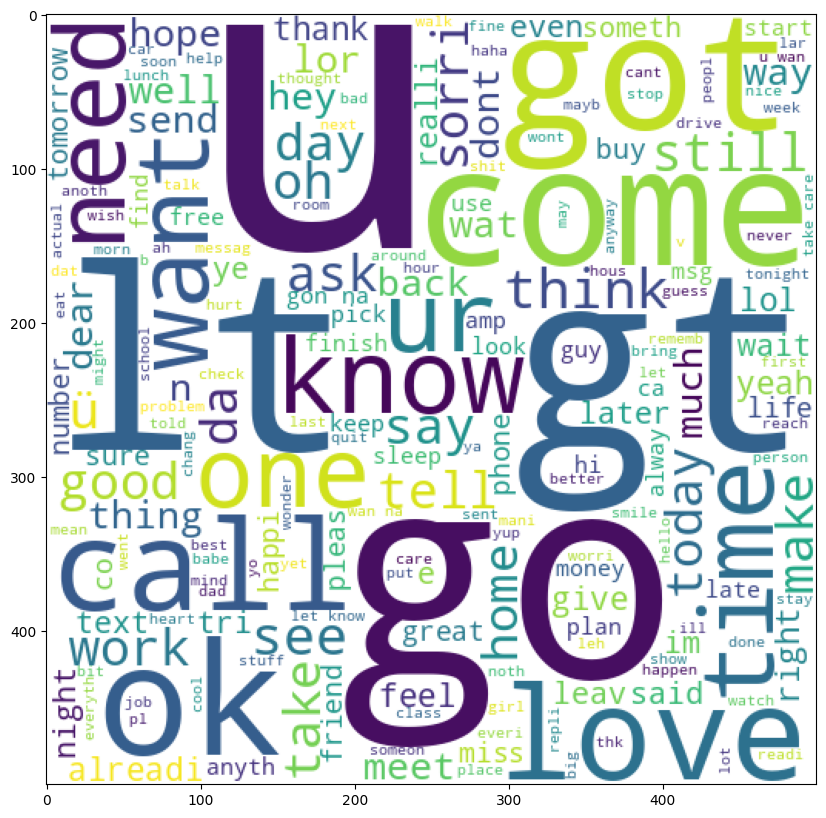

In [45]:
spam_wc = wc.generate(df[df['label'] == 0]['transform_text'].str.cat(sep=" "))
plt.figure(figsize=(15,10))
plt.imshow(spam_wc)

In [46]:
# spam_corpus = []
# for msg in df[df['label'] == 1]['transform_text'].tolist():
#     for word in msg.split():
#         spam_corpus.append(word)

In [47]:
# len(spam_corpus)

# 4. Model Building

In [48]:
# CV = CountVectorizer()
# tfidf = TfidfVectorizer(max_features=3000)

In [49]:
x = df['text']

In [50]:
x.shape

(13179,)

In [51]:
y = df['label'].values

In [52]:
from sklearn.model_selection import train_test_split

In [53]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=2)

In [54]:
print(x_train.size)
print(x_test.size)

10543
2636


In [55]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.ensemble import BaggingClassifier
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.ensemble import GradientBoostingClassifier
# from xgboost import XGBClassifier

# from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,classification_report

In [56]:
# svc = SVC(kernel='sigmoid', gamma=1.0)
# knc = KNeighborsClassifier()
# mnb = MultinomialNB()
# dtc = DecisionTreeClassifier(max_depth=5)
# lrc = LogisticRegression(solver='liblinear', penalty='l1')
# rfc = RandomForestClassifier(n_estimators=50, random_state=2)
# abc = AdaBoostClassifier(n_estimators=50, random_state=2)
# bc = BaggingClassifier(n_estimators=50, random_state=2)
# etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
# gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
# xgb = XGBClassifier(n_estimators=50,random_state=2)

In [57]:
# clfs = {
#     'SVC' : svc,
#     'KN' : knc, 
#     'NB': mnb, 
#     'DT': dtc, 
#     'LR': lrc, 
#     'RF': rfc, 
#     'AdaBoost': abc, 
#     'BgC': bc, 
#     'ETC': etc,
#     'GBDT':gbdt,
#     'xgb':xgb
# }

In [58]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# def train_classifier(clf, x_train, y_train, x_test, y_test, show_report=False):
    
#     # Train
#     clf.fit(x_train, y_train)
    
#     # Predict
#     y_pred = clf.predict(x_test)
    
#     # Metrics
#     accuracy  = accuracy_score(y_test, y_pred)
#     precision = precision_score(y_test, y_pred, average='macro')
#     recall    = recall_score(y_test, y_pred, average='macro')
#     f1        = f1_score(y_test, y_pred, average='macro')
    
#     # Optional detailed report
#     if show_report:
#         print("\nClassification Report:\n")
#         print(classification_report(y_test, y_pred))
    
#     return accuracy, precision, recall, f1


In [59]:
# train_classifier(svc,x_train,y_train,x_test,y_test)

In [60]:
# accuracy_scores = []
# precision_scores = []
# recall_scores = []
# f1_scores = []

# for name, clf in clfs.items():
    
#     print("\n==============================")
#     print("Model:", name)
    
#     acc, prec, rec, f1 = train_classifier(
#         clf,
#         x_train, y_train,
#         x_test, y_test,
#         show_report=True   # 👈 yahin classification_report aayega
#     )
    
#     print("Accuracy :", acc)
#     print("Precision:", prec)
#     print("Recall   :", rec)
#     print("F1 Score :", f1)
    
#     accuracy_scores.append(acc)
#     precision_scores.append(prec)
#     recall_scores.append(rec)
#     f1_scores.append(f1)


In [61]:
# performance_df = pd.DataFrame({
#     'Algorithm': clfs.keys(),
#     'Accuracy' : accuracy_scores,
#     'Precision': precision_scores,
#     'Recall'   : recall_scores,
#     'F1 Score' : f1_scores
# }).sort_values('Recall', ascending=False)   # 👈 Recall focus


In [62]:
import pickle
# import numpy as np

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [63]:
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=30000,
        ngram_range=(1, 2),
        stop_words="english"
    )),
    
    ("model", ExtraTreesClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])


In [64]:
pipeline.fit(x_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=30000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('model',
                 ExtraTreesClassifier(class_weight='balanced', n_estimators=300,
                                      n_jobs=-1, random_state=42))])

In [65]:
y_pred = pipeline.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.9522003034901366

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1606
           1       0.90      0.86      0.88       522
           2       0.86      0.89      0.88       508

    accuracy                           0.95      2636
   macro avg       0.92      0.92      0.92      2636
weighted avg       0.95      0.95      0.95      2636


Confusion Matrix:

[[1606    0    0]
 [   0  450   72]
 [   5   49  454]]


In [66]:
with open("spam_classifier_extratrees.pkl", "wb") as f:
    pickle.dump(pipeline, f)

print("✅ PKL file saved successfully")


✅ PKL file saved successfully


In [67]:
df.sample(10)

,label,text,num_char,num_words,num_sentence,transform_text
9753,2,bring what it takes 2 take part in the wrc ral...,161,38,3,bring take 2 take part wrc ralli oz u lucozad ...
7086,1,private! your 2003 account statement for 07808...,143,24,3,privat 2003 account statement 07808247860 show...
3145,0,"HEY THERE BABE, HOW U DOIN? WOT U UP 2 2NITE L...",58,17,2,hey babe u doin wot u 2 2nite love anni x
8133,2,ur cash-balance is currently 500 pounds - to m...,154,26,2,ur current 500 pound maxim ur institution coll...
1834,0,Are you at work right now ?,27,7,1,work right
6666,1,urgent! this is the 2nd attempt to touch u!u e...,150,24,4,urgent 2nd attempt touch u u experi advanc 090...
275,0,But pls dont play in others life.,33,8,1,pl dont play other life
10465,0,"Usf I guess, might as well take 1 car",37,10,1,usf guess might well take 1 car
2147,0,I'm on the bus. Love you,24,8,2,bu love
12192,0,But i'll b going 2 sch on mon. My sis need 2 t...,55,17,2,b go 2 sch mon si need 2 take smth


In [68]:
df['text'][6077]

'todays vodafone numbers ending 5263 represent selected to experience a rs.2,00,000 award. if you have a match please call 6200992462 quote claim code 4267 standard rates apply'